In [ ]:
!pip install kornia
!pip install fastai==2.5.3

In [1]:
import random
from pathlib import Path

import fastai
import kornia
import torch
from torchvision import transforms
import torchvision.models as models
from fastai.vision.all import *
from fastai.vision.gan import *
from model import Generator, Discriminator
import loss

print(torch.__version__)
print(fastai.__version__)

set_seed(42, True)

1.9.1+cu111
2.5.3


In [2]:
#load vgg
normalize = Normalize.from_stats(*imagenet_stats)                                               #range [0,1] to imagenet range
normalize01=Normalize.from_stats(torch.tensor([-1., -1., -1.]), torch.tensor([2., 2., 2.]))     #range [-1,1] to range[0,1]
normalize11=Normalize.from_stats(torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5]))  #range [0,1] to range[-1,1]
vgg_m = vgg19_bn(True).features.cuda().eval().requires_grad_(False)
vgg_m = vgg_m[:37]  # conv4_4 without lrelu

def vgg(inputImage):
    return vgg_m(normalize(normalize01(inputImage)))

/home/user/anaconda3/envs/tf2/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


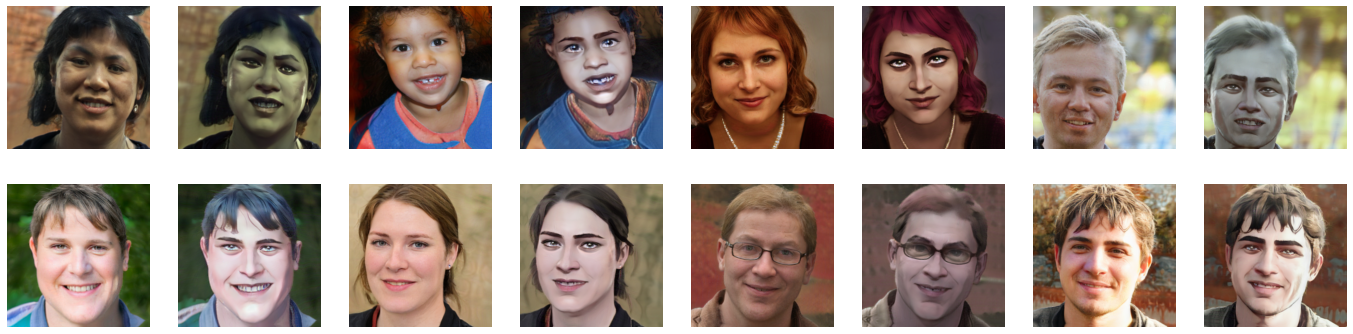

In [3]:
# load data
# # download animegan data
# !wget https://github.com/TachibanaYoshino/AnimeGAN/releases/download/dataset-1/dataset.zip
# !unzip dataset.zip -d downloadData

# animegan data
# path_photo = Path("downloadData/train_photo")    
# path_anime = Path("downloadData/Hayao/style")  
# path_anime_list = get_image_files(path_anime)

bs, size = 12, 256 
folderBase="stylegan3_data_arcane1"
path_photo = Path(folderBase+"/photo")
path_anime = Path(folderBase+"/anime") 


def get_dls(bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(0.1),
        #get_y=lambda x: random.choice(path_anime_list),
        get_y=lambda x: path_anime/x.name,   
        item_tfms=Resize(size),
        batch_tfms = [*aug_transforms(),normalize11] #range [-1,1]
    )
    dls = dblock.dataloaders(path_photo, bs=bs)
    dls.c = 3
    return dls

dls = get_dls(bs, size)
dls.show_batch(max_n=8)

In [4]:
#create generator
class VGGFeatureConverter(Callback):  #make generator create image that follow input vgg feature 
    def after_pred(self,):
        self.learn.pred=vgg(self.learn.pred)
        self.learn.yb=tuple([vgg(self.learn.x)])
        
learn_gen = Learner(dls, Generator(), loss_func=F.l1_loss, opt_func=partial(Adam, mom=0.5, sqr_mom=0.999),cbs=[VGGFeatureConverter])

In [5]:
# #pretrain generator
# lr = 3e-4
# learn_gen.fit(10, lr)
# learn_gen.save('gan-pretraining')

In [6]:
learn_gen.load('gan-pretraining')

In [8]:
learn_crit = Learner(dls_crit, Discriminator(), loss_func=AdaptiveLoss(MSELossFlat()))

In [10]:
# create gan
W_ADV = 1.0    # Real Fake
W_VGG = 10     # Identity            1.5 
W_STY = 100    # Style              2.5         
W_COL = 15.    # Color              15 
W_TV = 1.0     # Total variation
W_REL = 2.0    # Real
W_FAK = 1.2    # Fake
W_GRA = 1.2    # Gray
W_BLU = 0.8    # Blur
W_GP = 10.0    # gradient penalty


class GANLoss(GANModule):
    def __init__(self, gen_loss_func, crit_loss_func, gan_model):
        super().__init__()
        self.real_loss_fn, self.fake_loss_fn = loss.get_adversarial_losses_fn("lsgan")
        store_attr('gen_loss_func,crit_loss_func,gan_model')

    def set_input(self, x, y):
        store_attr('x,y')

    def blur(self, inputImage):
        return kornia.filters.gaussian_blur2d(inputImage, (5, 5), (1.1, 1.1))

    def gray(self, inputImage):
        return normalize11(transforms.Grayscale(num_output_channels=3)(normalize01(inputImage)))

    def yuv(self, inputImage):
        return kornia.color.yuv.rgb_to_yuv(normalize01(inputImage))

    def gram_matrix(self, x):
        n, c, h, w = x.size()
        x = x.view(n, c, -1)
        return (x @ x.transpose(1, 2))/(c*h*w)

    def generator(self, output, target):
        pred_fake = self.gan_model.critic(output)
        feat_gen = vgg(output)
        # feat_photo = vgg(self.x)
        # feat_gray = vgg(self.gray(self.y))
        gram_gen = self.gram_matrix(feat_gen)
        # gram_gray = self.gram_matrix(feat_gray)
        yuv_gen = self.yuv(output)
        yuv_photo = self.yuv(self.x)
        
        self.loss_adv = self.real_loss_fn(pred_fake)
        # self.loss_feat = F.l1_loss(feat_gen, feat_photo.detach())
        # self.loss_gram = F.l1_loss(gram_gen, gram_gray.detach())
        self.loss_color = F.l1_loss(yuv_gen[:, 0], yuv_photo[:, 0]) + F.smooth_l1_loss(yuv_gen[:, 1], yuv_photo[:, 1]) + F.smooth_l1_loss(yuv_gen[:, 2], yuv_photo[:, 2])
        self.loss_tv = F.mse_loss(output[..., 1:, :],output[..., :-1, :]) + F.mse_loss(output[..., :, 1:],output[..., :, :-1])
        # self.gen_loss = W_ADV * self.loss_adv + W_VGG * self.loss_feat + W_STY * self.loss_gram + W_COL * self.loss_color + W_TV * self.loss_tv
        
        feat_anime = vgg(self.y)
        self.loss_feat = F.l1_loss(feat_gen, feat_anime.detach())
        self.loss_gram = F.mse_loss(output,self.y)
        self.gen_loss = W_ADV * self.loss_adv + W_VGG * self.loss_feat + W_STY * self.loss_gram + W_COL * self.loss_color + W_TV * self.loss_tv
        
        return self.gen_loss

    def critic(self, pred_real, input):
        fake = self.gan_model.generator(self.x).requires_grad_(False)
        pred_fake = self.gan_model.critic(fake)
        pred_gray = self.gan_model.critic(self.gray(self.y))
        pred_blur = self.gan_model.critic(self.blur(self.y))                        
        
        self.loss_real = self.real_loss_fn(pred_real)
        self.loss_fake = self.fake_loss_fn(pred_fake)
        self.loss_gray = self.fake_loss_fn(pred_gray)
        self.loss_blur = self.fake_loss_fn(pred_blur)
        self.loss_gp = loss.gradient_penalty(self.gan_model.critic,self.y,fake,"none","line")
        self.crit_loss = W_REL * self.loss_real + W_FAK * self.loss_fake + W_GRA * self.loss_gray + W_BLU * self.loss_blur + W_GP * self.loss_gp
        return self.crit_loss

    
class GANLearner(Learner):
    def __init__(self, dls, generator, critic, gen_loss_func, crit_loss_func, switcher=None, gen_first=False,
                 switch_eval=True, show_img=True, clip=None, cbs=None, metrics=None, **kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        if switcher is None: switcher = FixedGANSwitcher()
        trainer = GANTrainer(clip=clip, switch_eval=switch_eval, gen_first=gen_first, show_img=show_img) 
        cbs = L(cbs) + L(trainer, switcher)
        metrics = L(metrics) + L(*LossMetrics('gen_loss,crit_loss,loss_adv,loss_feat,loss_gram,loss_color,loss_tv,loss_real,loss_fake,loss_gray,loss_blur,loss_gp'))
        super().__init__(dls, gan, loss_func=loss_func, cbs=cbs, metrics=metrics, **kwargs)

        

class InsertInputOnLoss(Callback):
    def before_batch(self,):
        self.loss_func.set_input(self.x, self.y)

    
learn = GANLearner(learn_gen.dls, learn_gen.model, learn_crit.model, learn_gen.loss_func, learn_crit.loss_func,
                   switcher=FixedGANSwitcher(), opt_func=partial(Adam, mom=0.5, sqr_mom=0.999), cbs=[InsertInputOnLoss, GANDiscriminativeLR(mult_lr=2.)])

In [11]:
lr = 2e-4
learn.fit(90, lr)
learn.save('0102_l2')
torch.save(learn.generator.state_dict(), "arcane_animegan_0.2.pt")

/home/user/anaconda3/envs/tf2/lib/python3.7/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/user/anaconda3/envs/tf2/lib/python3.7/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/user/anaconda3/envs/tf2/lib/python3.7/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Path('models/0102_l2.pth')

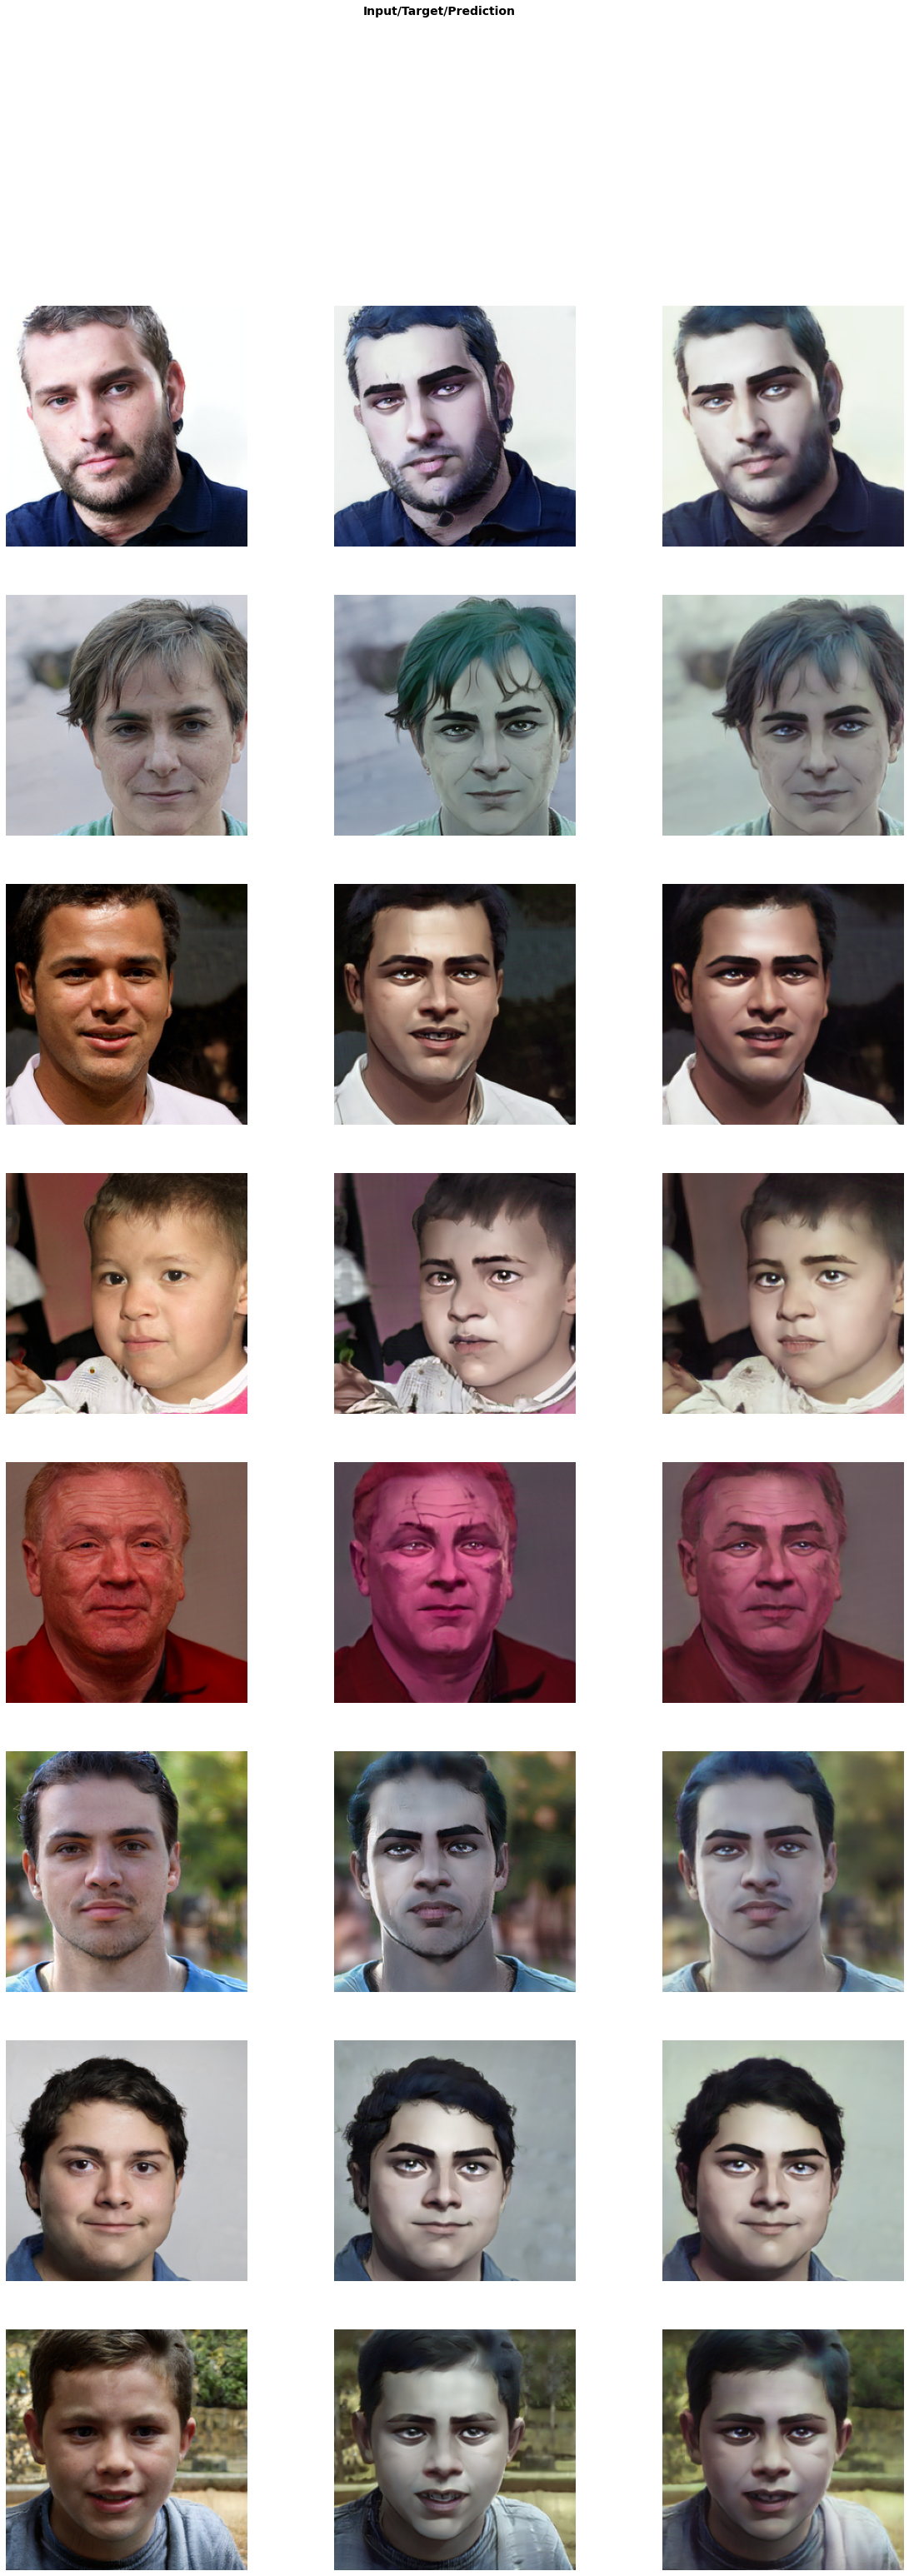

In [12]:
learn.show_results(max_n=8 , figsize=(20,50))